In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
from Codigo import *
import seaborn as sn
sn.set(style="whitegrid")

### Cargar Datos

In [18]:
Datos = Tachos('../Alemania_Reducida.csv')
data = Datos[['PIB (US$ a precios constantes de 2010)','Gasto de consumo final de los hogares (US$ a precios constantes de 2010)','Gasto nacional bruto (US$ a precios constantes de 2010)']].dropna(axis = 0)
data.columns = ['PIB','Inversión','Gasto']
data.dropna(axis =1, inplace= True)
data.index = pd.date_range(start='1970-12-31', periods=len(data), freq='Y')
data['Inversión'] = np.log(data['Inversión'])
data['Inversión'] = data['Inversión'].diff()
data.dropna(axis =0, inplace= True)

### Analisis de Estacionariedad a las Variables

In [19]:
DFuller(data['PIB'])
DFuller(data['Gasto'])
DFuller(data['Inversión'])

Estadístico ADF: -0.674795188364568
Valor p: 0.8531705873698825
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
Estadístico ADF: -0.518195796755569
Valor p: 0.8884165316955568
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
Estadístico ADF: -4.489550254854164
Valor p: 0.00020536824505229672
Rechazamos la hipótesis nula; la serie es estacionaria.


In [20]:
data['Inversión'] = data['Inversión'].diff()
data.dropna(axis =0 ,inplace= True)

### Amalisis de Correlacion de las Variables

### Analisis de Cointegración

In [21]:
print('Al 99% de confianza')
Johansen_Test(data,1,0,2)

Al 99% de confianza
Matriz de Valores Criticos vs Maximo Valor Propio
            cvm     eigv        Hipotesis
r = 0     2.7055    71.6775    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     3.8415    18.6277    Se rechaza r = 1, existe mas de 1 relación/nes de cointegración
r = 2     6.6349    3.4721    No hay suficiente evidencia para rechazar la hipótesis nula de r = 2.
Tabla de Valores Criticos vs Traza Estadistica
            cvt     TS          Hipotesis
r = 0     2.7055    93.7774    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     3.8415    22.0999    Se rechaza r = 1, existe mas de 1 relación/nes de cointegración
r = 2     6.6349    3.4721    No hay suficiente evidencia para rechazar la hipótesis nula de r = 2.


### Modelo Inicial

In [22]:

lag_order = select_order(data, maxlags= 10, deterministic= 'n', seasons= 0)

print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 0, FPE -> 1, HQIC ->  1>


In [23]:
model = VECM(data ,coint_rank= 2, k_ar_diff= 10)
result = model.fit()
alpha_matrix = result.alpha
print("Matriz de Coeficientes de Corrección de Errores (alpha):")
print(alpha_matrix)


Matriz de Coeficientes de Corrección de Errores (alpha):
[[-3.69780771e-01  1.35877272e+13]
 [ 4.66344263e-14 -9.91102212e+00]
 [ 8.52071601e-02 -3.26142043e+12]]


In [24]:
print(result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation PIB
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
L1.PIB           -0.6464      0.277     -2.336      0.020      -1.189      -0.104
L1.Inversión  -1.305e+13   8.95e+12     -1.457      0.145   -3.06e+13     4.5e+12
L1.Gasto          0.3639      0.457      0.796      0.426      -0.532       1.260
L2.PIB           -0.9213      0.276     -3.338      0.001      -1.462      -0.380
L2.Inversión  -1.338e+13   8.35e+12     -1.602      0.109   -2.97e+13    2.99e+12
L2.Gasto          0.8707      0.485      1.795      0.073      -0.080       1.821
L3.PIB           -0.1550      0.467     -0.332      0.740      -1.071       0.761
L3.Inversión    -1.1e+13   8.12e+12     -1.355      0.175   -2.69e+13    4.92e+12
L3.Gasto         -0.7065      0.546     -1.293      0.196      -1.777       0.364
L4.PIB         

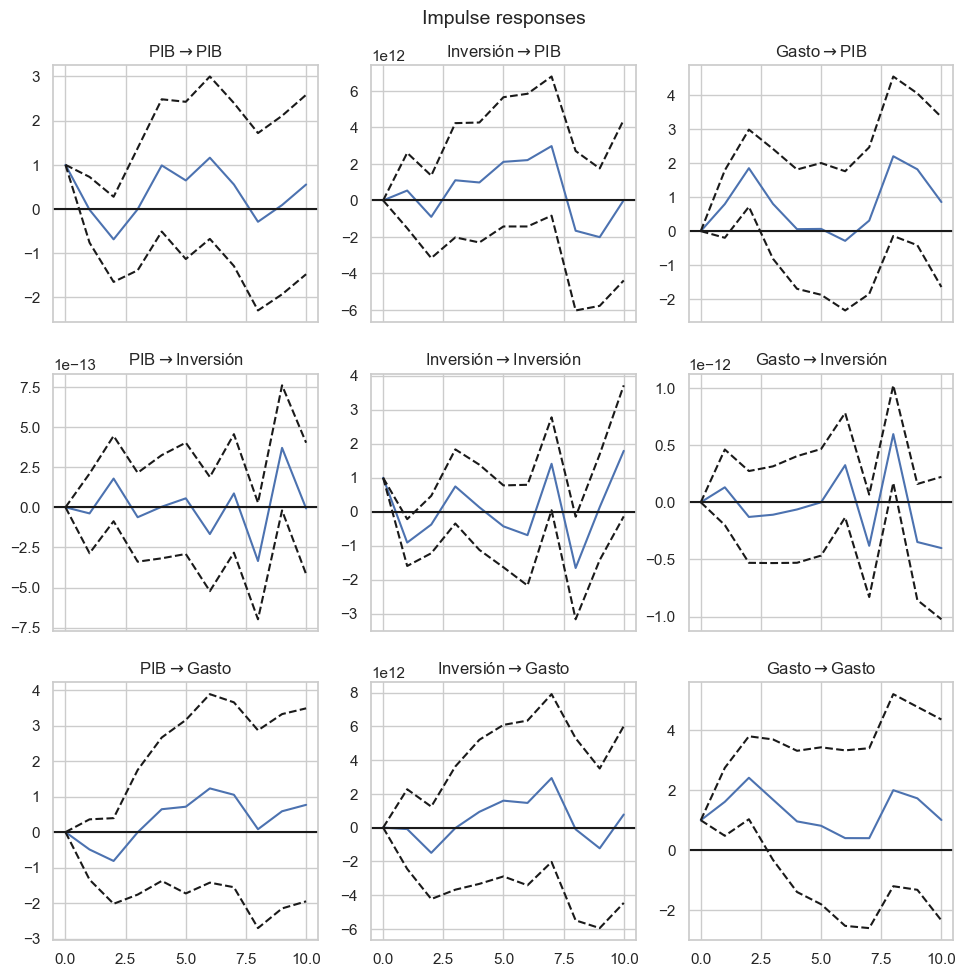

In [25]:
# Paso 6: Análisis de Impulsos-Respuestas
irf = result.irf(periods=10)
irf.plot()
plt.show()

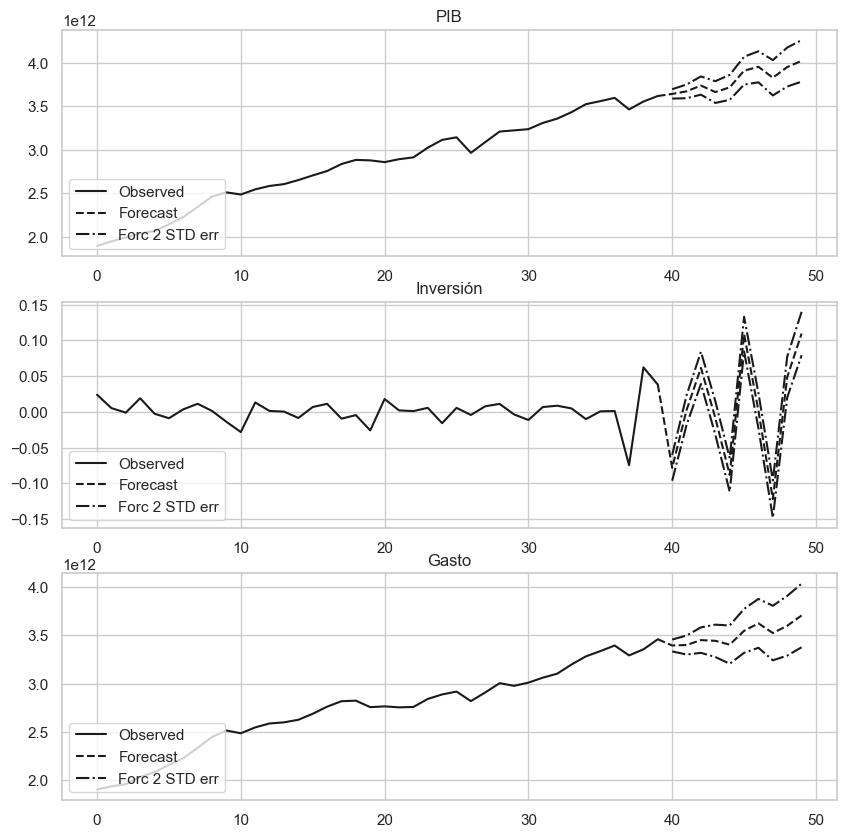

In [27]:
result.plot_forecast(steps = 10)